In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))


from log_processing import process_log, from_csv

In [10]:
round = 2

a0, t0 = from_csv(round, 0, dir="../../data")
a1, t1 = from_csv(round, 1, dir="../../data")
a2, t2 = from_csv(round, 2, dir="../../data")

In [12]:
croissant = a0[a0["product"] == "CROISSANTS"]
jam = a0[a0["product"] == "JAMS"]
djembe = a0[a0["product"] == "DJEMBES"]
pb1 = a1[a1["product"] == "PICNIC_BASKET1"]
pb2 = a1[a1["product"] == "PICNIC_BASKET2"]

<Axes: >

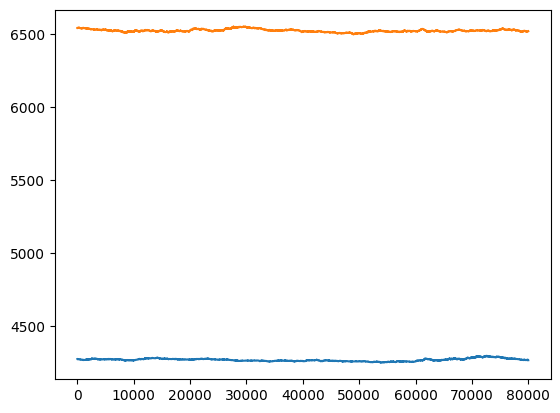

In [15]:
croissant["mid_price"].plot()
jam["mid_price"].plot()